## Calculate Evaluation Metrics on Mask R-CNN Keypoint Model

In [1]:
USE_GPU    = False
MODEL_NAME = "run1"

%matplotlib inline
import importlib
import os

if not USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import imgaug
import json

# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs", MODEL_NAME)

c:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from coco import coco_keypoints

# COCO dataset dir
COCO_DATA_DIR = "A:/Programming/DeepLearningDatasets/coco" if os.path.isdir("A:/Programming/DeepLearningDatasets/coco") else os.path.join(ROOT_DIR, "data/coco")

# Prepare dataset
dataset_val = coco_keypoints.CocoDataset()
dataset_val.load_coco(COCO_DATA_DIR, subset="val", year="2017", auto_download=True)
dataset_val.prepare()

Will use images in A:/Programming/DeepLearningDatasets/coco/val2017
Will use annotations in A:/Programming/DeepLearningDatasets/coco/annotations/person_keypoints_val2017.json
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


## Initialize Model From Weights

In [3]:
class InferenceConfig(coco_keypoints.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    BACKBONE = "resnet50"
    NUM_CLASSES = dataset_val.num_classes
    NUM_KEYPOINTS = dataset_val.num_kp_classes
    RPN_NMS_THRESHOLD = 0.5
    
config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  A:\Programming\Pose_RCNN\logs\run1\coco_keypoints20180606T2342\mask_rcnn_coco_keypoints_0020.h5


## Generate Detections
Detections are written to ```MODEL_DIR/detections.json```

In [4]:
def unmold_detections(result, dataset, image_id, config):
    # Get scale and padding for image
    image_info = dataset.image_info[image_id]
    w, h = image_info["width"], image_info["height"]
    _, window, scale, padding, crop =\
        utils.resize_image(np.zeros((h, w, 3)),
                           min_dim=config.IMAGE_MIN_DIM,
                           max_dim=config.IMAGE_MAX_DIM,
                           min_scale=config.IMAGE_MIN_SCALE,
                           mode=config.IMAGE_RESIZE_MODE)
    pad_top, pad_bot, pad_left, pad_right = padding[0][0], padding[0][1], padding[1][0], padding[1][1]
    
    # Generate detections
    detections = []
    for instance_masks, score in zip(result["kp_masks"], result["scores"]):
        keypoints = []
        for kp_mask in instance_masks:
            kpy, kpx = np.unravel_index(np.argmax(kp_mask, axis=None), kp_mask.shape)
            kpx = (kpx - pad_left) / scale
            kpy = (kpy - pad_top) / scale
            keypoints.append(int(kpx))
            keypoints.append(int(kpy))
            keypoints.append(1)

        detections.append({
            "image_id": int(image_info["id"]),
            "category_id": 1,
            "keypoints": keypoints,
            "score": float(score)
        })
    return detections

In [ ]:
detections = []
N = len(dataset_val.image_ids)
for image_id, image_info in zip(dataset_val.image_ids, dataset_val.image_info):
    print("image_id",image_id)
    if image_id % 10 == 0: print("Processing {}/{}...".format(image_id+1, N))
    
    # Load an image from the validation set
    image = modellib.load_image_gt(dataset_val, config, image_id)[0]

    # Detect keypoints
    detection_start_time = time.time()
    result = model.detect([image])[0]
    print("Detection time {}s".format(time.time() - detection_start_time))
    
    detections.extend(unmold_detections(result, dataset_val, image_id, config))
    
# Save data to .json
with open(os.path.join(MODEL_DIR, "detections.json"), "w") as f:
    json.dump(detections, f)

## Coco-analyze

In [4]:
## general imports
import json
import numpy as np

## COCO imports
from analyze.pycocotools.coco import COCO
from analyze.pycocotools.cocoeval import COCOeval
from analyze.pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [5]:
## set paths
dataDir  = COCO_DATA_DIR
dataType = "val2017"
annType  = "person_keypoints"
teamName = "pose_rcnn"

annFile  = os.path.join(COCO_DATA_DIR, "annotations/{}_{}.json".format(annType, dataType))
resFile  = os.path.join(MODEL_DIR, "detections.json")

print("{:10}[{}]".format("annFile:",annFile))
print("{:10}[{}]".format("resFile:",resFile))

gt_data   = json.load(open(annFile,"rb"))
imgs_info = {i["id"]:{"id":i["id"] ,
                      "width":i["width"],
                      "height":i["height"]}
                       for i in gt_data["images"]}

annFile:  [A:/Programming/DeepLearningDatasets/coco\annotations/person_keypoints_val2017.json]
resFile:  [A:\Programming\Pose_RCNN\logs\run1\detections.json]


In [6]:
team_dts = json.load(open(resFile,"rb"))
team_dts = [d for d in team_dts if d["image_id"] in imgs_info]

team_img_ids = set([d["image_id"] for d in team_dts])
print("Loaded [{}] instances in [{}] images.".format(len(team_dts),len(imgs_info)))

## load ground truth annotations
coco_gt = COCO( annFile )

## initialize COCO detections api
coco_dt   = coco_gt.loadRes( team_dts )

## initialize COCO analyze api
coco_analyze = COCOanalyze(coco_gt, coco_dt, "keypoints")

Loaded [59420] instances in [5000] images.
loading annotations into memory...
Done (t=0.53s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.30s)
creating index...
index created!


532481


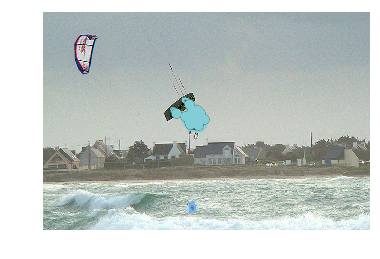

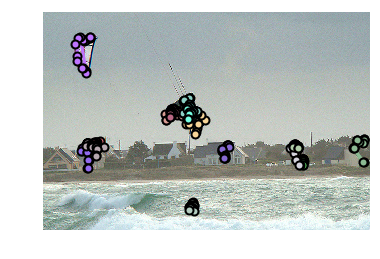

In [7]:
import skimage.io as io

img_id = list(team_img_ids)[0]
print(img_id)

# Load image
img = coco_gt.loadImgs(img_id)[0]
I = io.imread(img['coco_url'])

plt.imshow(I); plt.axis('off')
anns_gt = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
coco_gt.showAnns(anns_gt)
plt.show()

plt.imshow(I); plt.axis('off')
anns_dt = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))
coco_dt.showAnns(anns_dt)
#coco_dt.showAnns(coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id)))
plt.show()

In [8]:
kpx_dt, kpy_dt = np.array(anns_dt[0]["keypoints"][0::3]), np.array(anns_dt[0]["keypoints"][1::3])
kpx_gt, kpy_gt = np.array(anns_gt[0]["keypoints"][0::3]), np.array(anns_gt[0]["keypoints"][1::3])
print(np.sum(np.sqrt((kpx_dt - kpx_gt) ** 2 + (kpy_dt - kpy_gt) ** 2)))

4527.092624757598


<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=12.60s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.28s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.136
 Average Precision  (AP) @[ IoU=0.55      | area=   all | maxDets= 20 ] = 0.087
 Average Precision  (AP) @[ IoU=0.60      | area=   all | maxDets= 20 ] = 0.053
 Average Precision  (AP) @[ IoU=0.65      | area=   all | maxDets= 20 ] = 0.031
 Average Precision  (AP) @[ IoU=0.70      | area=   all | maxDets= 20 ] = 0.017
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 20 ] = 0.007
 Average Precision  (AP) @[ IoU=0.80      | area=   all | maxDets= 20 ] = 0.005
 Average Precision  (AP) @[ IoU=0.85      | area=   all | maxDets= 20 ] = 0.005
 Average Precision  (AP) @[ IoU=0.90      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] 

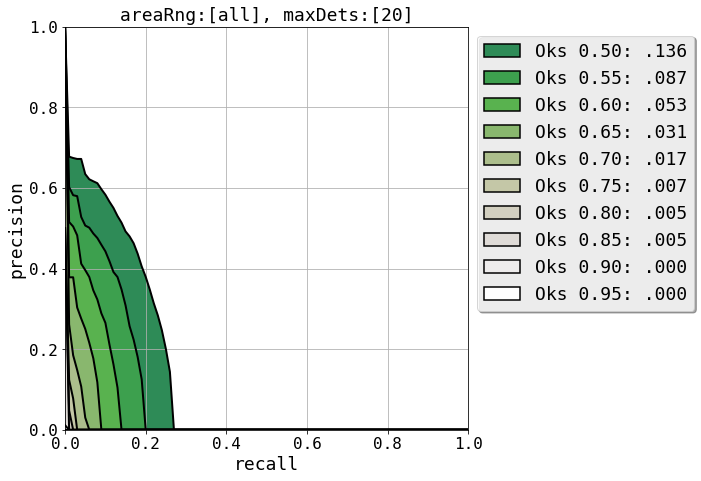

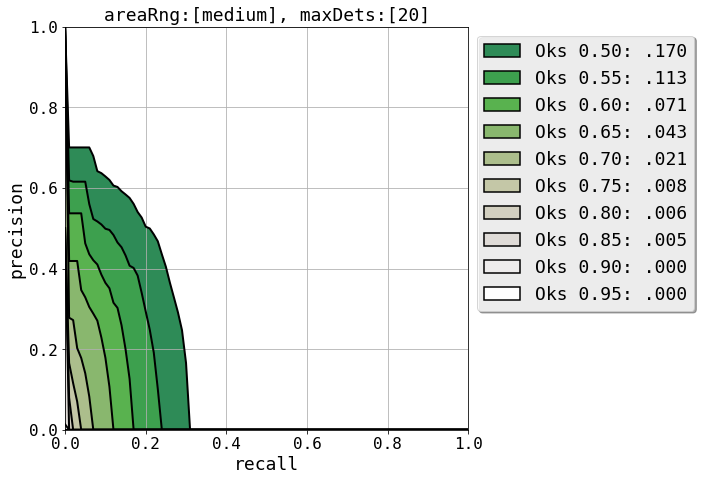

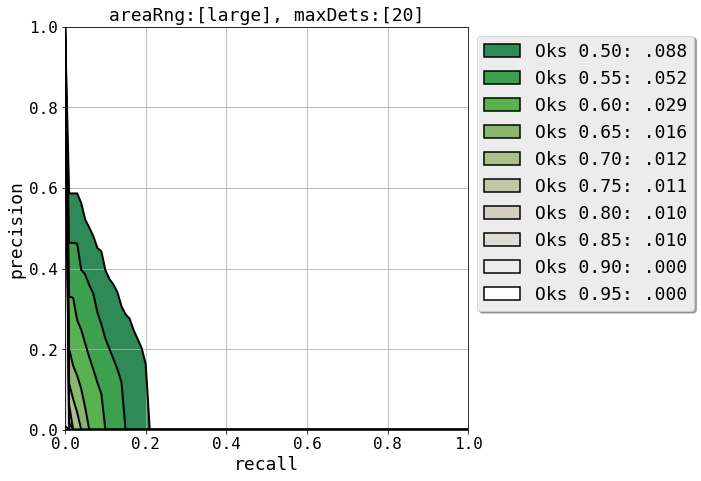

In [9]:
# use evaluate() method for standard coco evaluation
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.evaluate(verbose=True, makeplots=True)

In [11]:
## NOTE: the values below are all default

# set OKS threshold of the extended error analysis
coco_analyze.params.oksThrs       = [.05,.50,.95]

# set OKS threshold required to match a detection to a ground truth
coco_analyze.params.oksLocThrs    = .1

# set KS threshold limits defining jitter errors
coco_analyze.params.jitterKsThrs = [.5,.85]

# set the localization errors to analyze and in what order
# note: different order will show different progressive improvement
# to study impact of single error type, study in isolation
coco_analyze.params.err_types = ["miss","swap","inversion","jitter"]

# area ranges for evaluation
# "all" range is union of medium and large
coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]] #[96 ** 2, 1e5 ** 2],[32 ** 2, 96 ** 2]
coco_analyze.params.areaRngLbl    = ["all"] # "large","medium" 

coco_analyze.params.maxDets = [20]

<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.64s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.04s).
<mrr:2.0>Verbose Summary:
 Average Precision  (AP) @[ IoU=0.05      | area=   all | maxDets= 20 ] = 0.685
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.136
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.000
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=   all | maxDets= 20 ] = 0.273
 Average Precision  (AP) @[ IoU=0.05:0.95 | area=medium | maxDets= 20 ] = -1.000
 Average Precision  (AP) @[ IoU=0.05:0.95 | area= large | maxDets= 20 ] = -1.000
 Average Recall     (AR) @[ IoU=0.05      | area=   all | maxDets= 20 ] = 0.852
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets= 20 ] = 0.264
 Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets= 20 ] = 0.000
 Average Recall     (AR) @[ IoU=0.05:0.95 | area=   all | maxDets= 20 ]

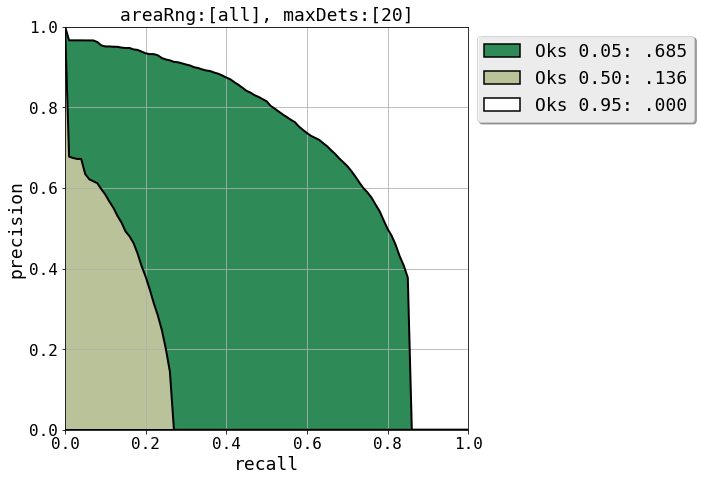

In [14]:
coco_analyze.evaluate(verbose=True, makeplots=True)

In [12]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : default errors types are ["jitter","inversion","swap","miss"]
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_bkgd   : analyze background false positives and false negatives (default: True)

coco_analyze.analyze(check_kpts=True, check_scores=True, check_bckgd=True)

Analyzing keypoint errors...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.08s).
DONE (t=13.28s).
Analyzing detection scores...
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=17.22s).
DONE (t=60.75s).
Analyzing background false positives and false negatives...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.53s).
DONE (t=9.28s).


In [13]:
# use summarize() method to get the results after progressive correction of errors
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.summarize(makeplots=True)

TypeError: summarize() got an unexpected keyword argument 'verbose'

In [ ]:
## print the performance summary 
for stat in coco_analyze.stats: print(stat)

In [16]:
## after analyze() has been called the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts["all"]

i = 17
# info on keypoint detection localization error
print "good: %s"%corrected_dts[i]["good"]
print "miss: %s"%corrected_dts[i]["miss"]
print "swap: %s"%corrected_dts[i]["swap"]
print "inv.: %s"%corrected_dts[i]["inversion"]
print "jit.: %s\n"%corrected_dts[i]["jitter"]

# corrected keypoint locations
print "predicted keypoints:\n %s"%corrected_dts[i]["keypoints"]
print "corrected keypoints:\n %s\n"%corrected_dts[i]["opt_keypoints"]

# optimal detection score
print "original score: %s"%corrected_dts[i]["score"]
print "optimal score:  %s\n"%corrected_dts[i]["opt_score"]

SyntaxError: Missing parentheses in call to 'print'. Did you mean print("good: %s"%corrected_dts[i]["good"])? (<ipython-input-16-b259b4f71605>, line 8)

In [ ]:
## after summarize() has been called the following variables are available

# list of the false positive detections and missed ground-truth annotations
false_pos_dts = coco_analyze.false_pos_dts
false_neg_gts = coco_analyze.false_neg_gts
for oks in coco_analyze.params.oksThrs:
    print "Oks:[%.2f] - Num.FP:[%d] - Num.FN:[%d]"%(oks,len(false_pos_dts["all",str(oks)]),len(false_neg_gts["all",str(oks)]))